/tmp/ipython-input-3976737355.py:74: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt(np.dot(point_vec, point_vec) - projection**2)


Analysis Results After Removing Specified Features:
Elbow Point Found by Method 1 (Maximum Curvature):
Position: 17th feature
Feature Name: first_generation_student_Yes
Cumulative Importance: 89.73%
Number of Features: 17

Elbow Point Found by Method 2 (Maximum Distance):
Position: 33th feature
Feature Name: gender_Other
Cumulative Importance: 100.00%
Number of Features: 33

Detailed Comparison for Key Feature Counts:
Features | Cumulative | Last Feature
--------------------------------------------------
   6     |   62.76   % | assignment_submission_rate
   8     |   69.66   % | stress_level_Medium
   10    |   75.43   % | stress_level_Low
   12    |   80.88   % | age
   15    |   87.06   % | motivation_level
   17    |   89.73   % | first_generation_student_Yes


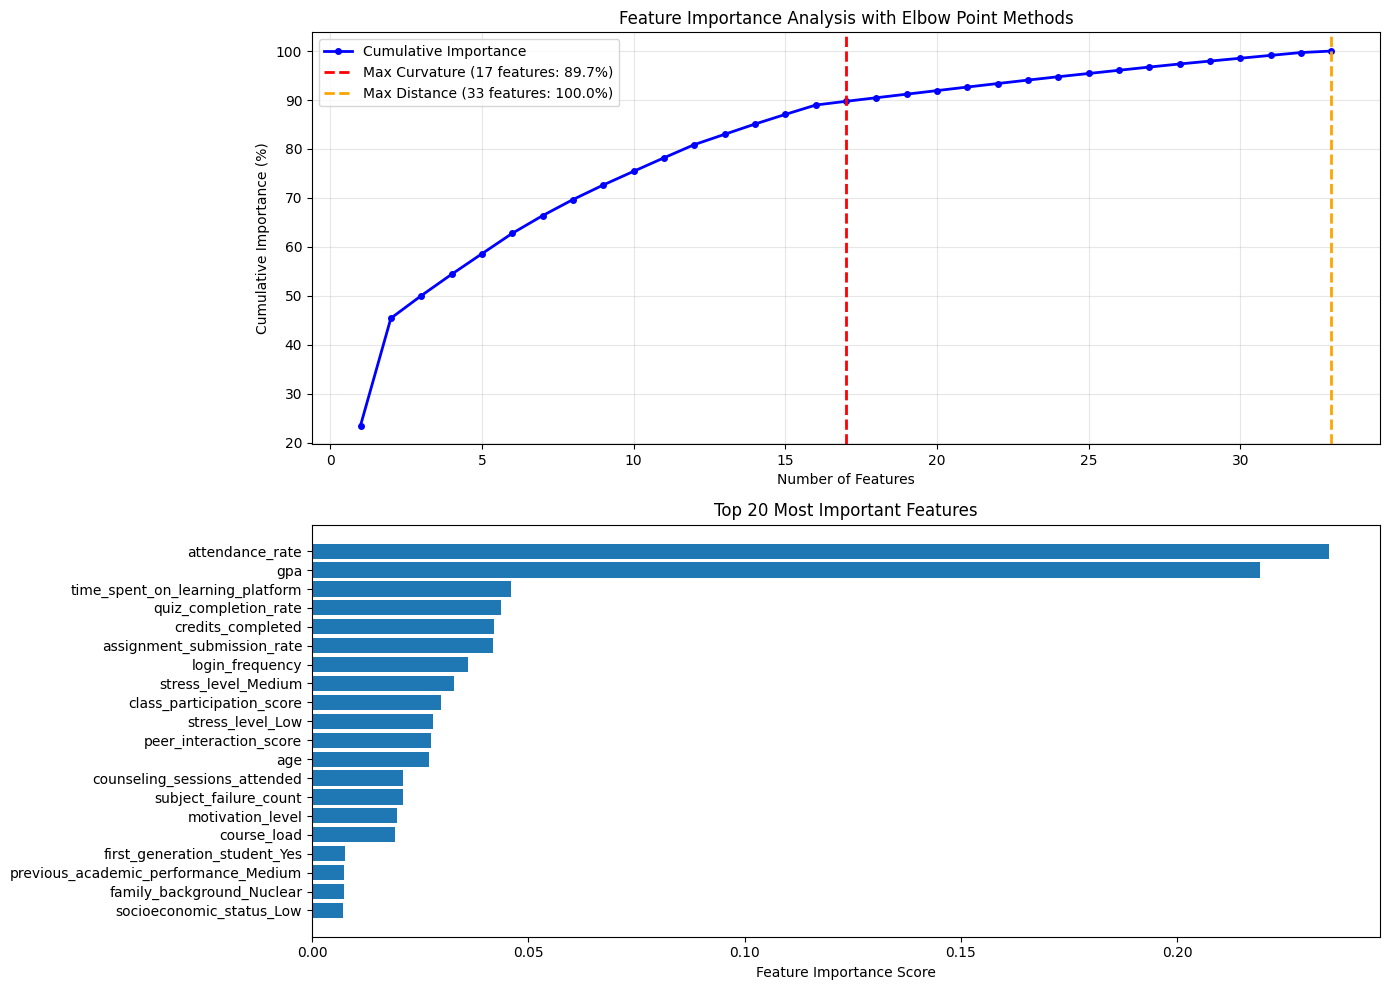


RECOMMENDED FEATURE SUBSETS

1. CONSERVATIVE APPROACH (Method 1 - 17 features):
   Cumulative Importance: 89.73%
   Features:
    1. attendance_rate
    2. gpa
    3. time_spent_on_learning_platform
    4. quiz_completion_rate
    5. credits_completed
    6. assignment_submission_rate
    7. login_frequency
    8. stress_level_Medium
    9. class_participation_score
   10. stress_level_Low
   11. peer_interaction_score
   12. age
   13. counseling_sessions_attended
   14. subject_failure_count
   15. motivation_level
   16. course_load
   17. first_generation_student_Yes

2. AGGRESSIVE APPROACH (Method 2 - 33 features):
   Cumulative Importance: 100.00%
   Features:
    1. attendance_rate
    2. gpa
    3. time_spent_on_learning_platform
    4. quiz_completion_rate
    5. credits_completed
    6. assignment_submission_rate
    7. login_frequency
    8. stress_level_Medium
    9. class_participation_score
   10. stress_level_Low
   11. peer_interaction_score
   12. age
   13. counselin

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Read data
df = pd.read_csv('https://raw.githubusercontent.com/Salina-Huang/AI-in-ED-Multi-dimensional-Student-analytics-for-dropout-risk-prediction/refs/heads/main/dat_preparation_onehot.csv')
X = df.drop(['dropout_status'], axis=1)
y = df['dropout_status']

# Remove specified features
features_to_remove = ['engagement_score','Unnamed: 0']
X = X.drop(features_to_remove, axis=1)

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'score': importances})
feature_importances = feature_importances.sort_values(by='score', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
feature_importances['cumulative_score'] = feature_importances['score'].cumsum()
feature_importances['percentage'] = feature_importances['cumulative_score'] * 100

# Find elbow point - Method 1: Using maximum curvature
def find_elbow_point(feature_importances):
    """Find elbow point by calculating curvature"""
    x = np.arange(len(feature_importances))
    y = feature_importances['percentage'].values

    # Calculate first derivative (slope)
    first_deriv = np.gradient(y, x)

    # Calculate second derivative (curvature)
    second_deriv = np.gradient(first_deriv, x)

    # Calculate curvature (approximation using curvature formula)
    curvature = np.abs(second_deriv) / (1 + first_deriv**2)**1.5

    # Find point with maximum curvature (excluding first 2 and last 2 points)
    elbow_idx = np.argmax(curvature[2:-2]) + 2

    return elbow_idx

# Find elbow point - Method 2: Using maximum angle change
def find_elbow_by_angle(feature_importances):
    """Find elbow point by calculating angle change"""
    x = np.arange(len(feature_importances))
    y = feature_importances['percentage'].values

    # Create line from first point to last point
    line_start = np.array([x[0], y[0]])
    line_end = np.array([x[-1], y[-1]])
    line_vec = line_end - line_start
    line_len = np.linalg.norm(line_vec)

    # Calculate distance from each point to this line
    distances = []
    for i in range(len(x)):
        point_vec = np.array([x[i], y[i]]) - line_start
        # Projection length
        projection = np.dot(point_vec, line_vec) / line_len
        # Perpendicular distance
        distance = np.sqrt(np.dot(point_vec, point_vec) - projection**2)
        distances.append(distance)

    elbow_idx = np.argmax(distances)
    return elbow_idx

# Find elbow points using both methods
elbow_idx1 = find_elbow_point(feature_importances)
elbow_idx2 = find_elbow_by_angle(feature_importances)

print("Analysis Results After Removing Specified Features:")
print("=" * 60)
print("Elbow Point Found by Method 1 (Maximum Curvature):")
print(f"Position: {elbow_idx1 + 1}th feature")
print(f"Feature Name: {feature_importances.loc[elbow_idx1, 'feature']}")
print(f"Cumulative Importance: {feature_importances.loc[elbow_idx1, 'percentage']:.2f}%")
print(f"Number of Features: {elbow_idx1 + 1}")

print("\nElbow Point Found by Method 2 (Maximum Distance):")
print(f"Position: {elbow_idx2 + 1}th feature")
print(f"Feature Name: {feature_importances.loc[elbow_idx2, 'feature']}")
print(f"Cumulative Importance: {feature_importances.loc[elbow_idx2, 'percentage']:.2f}%")
print(f"Number of Features: {elbow_idx2 + 1}")

# Display detailed comparison for key feature counts
print("\nDetailed Comparison for Key Feature Counts:")
print("Features | Cumulative | Last Feature")
print("-" * 50)
feature_counts = [6, 8, 10, 12, 15, elbow_idx1 + 1]
for n in feature_counts:
    if n <= len(feature_importances):
        importance = feature_importances.loc[n-1, 'percentage']
        feature_name = feature_importances.loc[n-1, 'feature']
        print(f"{n:^8} | {importance:^10.2f}% | {feature_name}")

# Plot cumulative feature importance curve and elbow points
plt.figure(figsize=(14, 10))

# Cumulative importance curve
plt.subplot(2, 1, 1)
plt.plot(range(1, len(feature_importances) + 1), feature_importances['percentage'],
         'b-', marker='o', linewidth=2, markersize=4, label='Cumulative Importance')

# Mark elbow points
plt.axvline(x=elbow_idx1 + 1, color='red', linestyle='--', linewidth=2,
           label=f'Max Curvature ({elbow_idx1 + 1} features: {feature_importances.loc[elbow_idx1, "percentage"]:.1f}%)')
plt.axvline(x=elbow_idx2 + 1, color='orange', linestyle='--', linewidth=2,
           label=f'Max Distance ({elbow_idx2 + 1} features: {feature_importances.loc[elbow_idx2, "percentage"]:.1f}%)')

plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Feature Importance Analysis with Elbow Point Methods')
plt.grid(True, alpha=0.3)
plt.legend()

# Top N feature importances
plt.subplot(2, 1, 2)
top_n = min(20, len(feature_importances))  # Show top 20 features
plt.barh(range(top_n), feature_importances['score'].head(top_n)[::-1])
plt.yticks(range(top_n), feature_importances['feature'].head(top_n)[::-1])
plt.xlabel('Feature Importance Score')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

# Output recommended feature subsets
print("\n" + "="*60)
print("RECOMMENDED FEATURE SUBSETS")
print("="*60)

print(f"\n1. CONSERVATIVE APPROACH (Method 1 - {elbow_idx1 + 1} features):")
print(f"   Cumulative Importance: {feature_importances.loc[elbow_idx1, 'percentage']:.2f}%")
print("   Features:")
for i in range(elbow_idx1 + 1):
    print(f"   {i+1:2d}. {feature_importances.loc[i, 'feature']}")

print(f"\n2. AGGRESSIVE APPROACH (Method 2 - {elbow_idx2 + 1} features):")
print(f"   Cumulative Importance: {feature_importances.loc[elbow_idx2, 'percentage']:.2f}%")
print("   Features:")
for i in range(elbow_idx2 + 1):
    print(f"   {i+1:2d}. {feature_importances.loc[i, 'feature']}")

# Display total number of remaining features
print(f"\nTotal Remaining Features: {len(X.columns)}")
print("All Remaining Features:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")